In [ ]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns
from research.datasets import CRSP

In [2]:
# Read in crsp monthly data

df = CRSP().df.copy()

df.head()

,permno,date,cusip,shrcd,exchcd,ticker,shrout,vol,prc,ret
0,10000,1986-02-28,68391610,10.0,3.0,OMFGA,3680.0,828.0,3.25000,-0.257143
1,10000,1986-03-31,68391610,10.0,3.0,OMFGA,3680.0,1078.0,4.43750,0.365385
2,10000,1986-04-30,68391610,10.0,3.0,OMFGA,3793.0,957.0,4.00000,-0.098592
3,10000,1986-05-30,68391610,10.0,3.0,OMFGA,3793.0,1074.0,3.10938,-0.222656
4,10000,1986-06-30,68391610,10.0,3.0,OMFGA,3793.0,1069.0,3.09375,-0.005025


In [3]:
# Cleaning

df = df[['permno', 'ticker', 'date', 'prc', 'ret']]

df['mdt'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m")
df['month'] = pd.to_datetime(df['date']).dt.strftime("%m")

df.head()

,permno,ticker,date,prc,ret,mdt,month
0,10000,OMFGA,1986-02-28,3.25000,-0.257143,1986-02,02
1,10000,OMFGA,1986-03-31,4.43750,0.365385,1986-03,03
2,10000,OMFGA,1986-04-30,4.00000,-0.098592,1986-04,04
3,10000,OMFGA,1986-05-30,3.10938,-0.222656,1986-05,05
4,10000,OMFGA,1986-06-30,3.09375,-0.005025,1986-06,06


In [4]:
# Calculate Reversal feature
window = 1
holding_period = 1 # Alternative is 6
holding_period_var = f'ret_{holding_period}'

# Log Returns
df['logret'] = np.log1p(df['ret'])

# Reversal from t-1 to t (also know as 1 month momentum)
df['rev'] = df.groupby('permno')['logret'].rolling(window,window).sum().reset_index(drop=True)
df['rev'] = df.groupby('permno')['rev'].shift(1) # Once for lag

# Holding period returns
df[holding_period_var] = df.groupby('permno')['logret'].rolling(holding_period,holding_period).sum().reset_index(drop=True)
df[holding_period_var] = df.groupby('permno')[holding_period_var].shift(-(holding_period-1))

df

,permno,ticker,date,prc,ret,mdt,month,logret,rev,ret_1
0,10000,OMFGA,1986-02-28,3.25000,-0.257143,1986-02,02,-0.297252,NaN,-0.297252
1,10000,OMFGA,1986-03-31,4.43750,0.365385,1986-03,03,0.311436,-0.297252,0.311436
2,10000,OMFGA,1986-04-30,4.00000,-0.098592,1986-04,04,-0.103797,0.311436,-0.103797
3,10000,OMFGA,1986-05-30,3.10938,-0.222656,1986-05,05,-0.251872,-0.103797,-0.251872
4,10000,OMFGA,1986-06-30,3.09375,-0.005025,1986-06,06,-0.005038,-0.251872,-0.005038
...,...,...,...,...,...,...,...,...,...,...
3785681,93436,TSLA,2023-08-31,258.07999,-0.034962,2023-08,08,-0.035588,0.021392,-0.035588
3785682,93436,TSLA,2023-09-29,250.22000,-0.030456,2023-09,09,-0.030929,-0.035588,-0.030929
3785683,93436,TSLA,2023-10-31,200.84000,-0.197346,2023-10,10,-0.219832,-0.030929,-0.219832
3785684,93436,TSLA,2023-11-30,240.08000,0.195379,2023-11,11,0.178463,-0.219832,0.178463


In [5]:
# Filtering by prc greater than 5 and months that momentum is known

df['prclag'] = df.groupby('permno')['prc'].shift(1)

df = df.query("rev == rev and prclag >= 5").reset_index(drop=True)

df

,permno,ticker,date,prc,ret,mdt,month,logret,rev,ret_1,prclag
0,10001,GFGC,1986-03-31,6.31250,0.025200,1986-03,03,0.024888,0.020203,0.024888,6.25000
1,10001,GFGC,1986-04-30,6.37500,0.009901,1986-04,04,0.009852,0.024888,0.009852,6.31250
2,10001,GFGC,1986-05-30,6.31250,-0.009804,1986-05,05,-0.009852,0.009852,-0.009852,6.37500
3,10001,GFGC,1986-06-30,6.12500,-0.013069,1986-06,06,-0.013155,-0.009852,-0.013155,6.31250
4,10001,GFGC,1986-07-31,6.06250,-0.010204,1986-07,07,-0.010256,-0.013155,-0.010256,6.12500
...,...,...,...,...,...,...,...,...,...,...,...
2857049,93436,TSLA,2023-08-31,258.07999,-0.034962,2023-08,08,-0.035588,0.021392,-0.035588,267.42999
2857050,93436,TSLA,2023-09-29,250.22000,-0.030456,2023-09,09,-0.030929,-0.035588,-0.030929,258.07999
2857051,93436,TSLA,2023-10-31,200.84000,-0.197346,2023-10,10,-0.219832,-0.030929,-0.219832,250.22000
2857052,93436,TSLA,2023-11-30,240.08000,0.195379,2023-11,11,0.178463,-0.219832,0.178463,200.84000


In [6]:
# Momentum decile bins
df['revbins'] = df.groupby("mdt")['rev'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) # I would like to not drop dulplicates

df

,permno,ticker,date,prc,ret,mdt,month,logret,rev,ret_1,prclag,revbins
0,10001,GFGC,1986-03-31,6.31250,0.025200,1986-03,03,0.024888,0.020203,0.024888,6.25000,3
1,10001,GFGC,1986-04-30,6.37500,0.009901,1986-04,04,0.009852,0.024888,0.009852,6.31250,4
2,10001,GFGC,1986-05-30,6.31250,-0.009804,1986-05,05,-0.009852,0.009852,-0.009852,6.37500,5
3,10001,GFGC,1986-06-30,6.12500,-0.013069,1986-06,06,-0.013155,-0.009852,-0.013155,6.31250,2
4,10001,GFGC,1986-07-31,6.06250,-0.010204,1986-07,07,-0.010256,-0.013155,-0.010256,6.12500,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2857049,93436,TSLA,2023-08-31,258.07999,-0.034962,2023-08,08,-0.035588,0.021392,-0.035588,267.42999,4
2857050,93436,TSLA,2023-09-29,250.22000,-0.030456,2023-09,09,-0.030929,-0.035588,-0.030929,258.07999,5
2857051,93436,TSLA,2023-10-31,200.84000,-0.197346,2023-10,10,-0.219832,-0.030929,-0.219832,250.22000,5
2857052,93436,TSLA,2023-11-30,240.08000,0.195379,2023-11,11,0.178463,-0.219832,0.178463,200.84000,0


In [7]:
# Form portfolios on reversal bins

# This line of code is for rebalancing every 6 months.
# df = df[(df['month'] == '01') | (df['month'] == '07')]

# Portfolio df for summary stats
port = df.groupby(['mdt', 'revbins'])[holding_period_var].mean().unstack(level=['revbins'])*100

# Drop rows from port where we don't know the holding return
port = port.dropna()

# Spread portfolio: Long loser. Short winner.
port['spread'] = port[0] - port[9]

port.head()

revbins,0,1,2,3,4,5,6,7,8,9,spread
mdt,,,,,,,,,,,
1926-02,-11.850867,-6.508648,-5.140516,-4.729509,-5.061009,-5.020571,-2.794921,-5.899191,-5.026619,-8.694506,-3.156361
1926-03,-14.856095,-15.562631,-13.438400,-10.024074,-10.507918,-7.507671,-8.375691,-7.182931,-6.219077,-9.034543,-5.821552
1926-04,-0.604924,4.876965,2.158319,3.430661,4.293036,2.690456,3.177755,4.595422,5.044894,1.306907,-1.911831
1926-05,-0.983190,-0.459154,-1.303887,-0.439606,-0.249077,1.981691,1.208581,-0.650654,0.332865,1.588642,-2.571831
1926-06,3.506204,4.688617,6.988552,4.255758,4.844182,5.252573,4.328474,3.585012,7.187445,2.868757,0.637447


In [8]:
# Summary

summary(port).loc[['count','mean','std','tstat']].round(3)

revbins,0,1,2,3,4,5,6,7,8,9,spread
count,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000
mean,0.270,0.430,0.436,0.555,0.544,0.540,0.422,0.266,0.030,-0.584,0.854
std,8.561,7.374,6.643,6.207,5.949,5.870,5.902,6.022,6.400,7.219,4.718
tstat,1.082,2.001,2.252,3.062,3.133,3.153,2.450,1.512,0.159,-2.771,6.203


/var/folders/5k/s9c0d19s0k7byf19zlnzgmjr0000gn/T/ipykernel_3467/817152262.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cum_ret.index = pd.to_datetime(cum_ret.index)


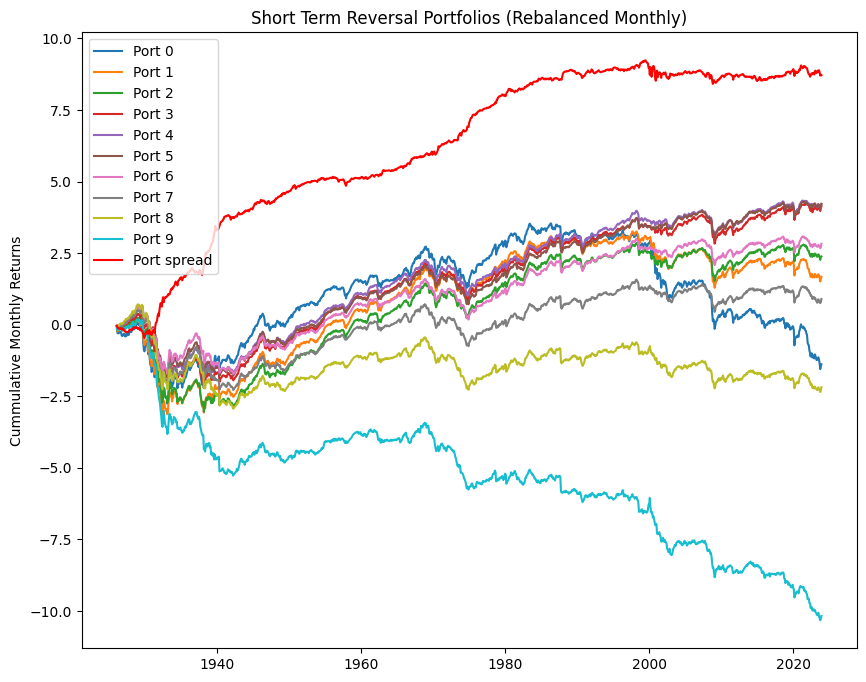

In [9]:
# Log return dataframe
log_ret = np.log1p(port/100)

# Cummulative return dataframe
cum_ret = log_ret.cumsum()
cum_ret.index = pd.to_datetime(cum_ret.index)

# Lineplot
plt.figure(figsize=(10,8))

for col in cum_ret.columns:
    color = 'red' if col == 'spread' else None
    plt.plot(cum_ret[col], label=f"Port {col}", color=color)

plt.title("Short Term Reversal Portfolios (Rebalanced Monthly)")
plt.ylabel("Cummulative Monthly Returns")
plt.legend()
plt.show()